## homens = mulheres

os homens tinham mts menos obs q mulheres para a fadiga de risco, ao equilibrar se fadiga,sexo igual em todas as combinacoes, resultados mt melhores

foi usado smote para aumentar alguns, e baixar outros

resultado overall da accutacy fica melhor, mas ao separar em homens e mulheres fica pior. para além disso perde se os nomes e datas se dps quisermos usar.

os graficos bivariados tbm ficam feios por assim dizer... nao recomendo a nao ser q tenhamos maus resultados com as redes neuronais e isso

### Import of libraries

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading of the file and one of the sheets

### Description of the variables

- deltaWt - fazer percentual

In [89]:
# The athletes' names are hiden, and only the initial name and gender are visible through the naming of each dataset

Athletes = {'F_f': '',
            'J_f': '',
            'F_m': '',
            'G_m': '',
            'V_f': '',
            'A_m': '',
            'I_f': ''
            }

# Importing the data to the Athletes dictionary
for i in Athletes:
    Athletes[i] = pd.read_excel('DataFatigInd.xlsx', sheet_name = i)
    Athletes[i]['U.A. Intensidade (ontem)'] =  Athletes[i]['U.A. Intensidade'].shift(1)
    Athletes[i]['Diferença Peso'] = Athletes[i]['Peso basal'].pct_change()
    Athletes[i]['Diferença Pulso'] = Athletes[i]['Pulso após 2 horas'] - Athletes[i]['Pulso basal']
    Athletes[i].rename(columns={'Data': 'Date',
                                'Nr dia': 'NrDay',
                                'Qualidade de Sono': 'QSleep',
                                'Horas de Cama': 'TSleep',
                                'Apetite': 'Appetite',
                                'Estado de Ânimo': 'StSpirit',
                                'Percepção Carga': 'pEffort',
                                'Pulso após 2 horas': 'ATHr',
                                'Pulso basal': 'Hr',
                                'U.A. Intensidade': 'uaI',
                                'ÍNDICE DE FADIGA': 'FatigInd',
                                'Peso basal': 'Wt',
                                'U.A. Intensidade (ontem)': 'uaI(-1)',
                                'Diferença Peso': 'DeltaWt (%)',
                                'Diferença Pulso': 'DeltaHrtwo'
                                }, inplace=True)
    Athletes[i]["Name"] = i
    Athletes[i]["Sex_F"] = 1 if i[-1] == "f" else 0
    Athletes[i]["SleepInd"] =  Athletes[i]["QSleep"] - Athletes[i]["TSleep"]
    
df = pd.concat(Athletes.values(), ignore_index=True)
df.drop(columns=['NrDay', 'QSleep', 'TSleep', 'Hr', 'ATHr', 'Wt'], inplace=True)

df

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_7529/1740791164.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  Athletes[i]['Diferença Peso'] = Athletes[i]['Peso basal'].pct_change()


,Date,Appetite,StSpirit,pEffort,uaI,FatigInd,uaI(-1),DeltaWt (%),DeltaHrtwo,Name,Sex_F,SleepInd
0,2019-10-18,6.0,4.0,6.0,1.76,99.809325,NaN,NaN,2.0,F_f,1,-3.50
1,2019-10-19,7.0,7.0,7.0,1.66,87.095325,1.76,0.000000,-6.0,F_f,1,-7.00
2,2019-10-20,7.0,3.0,4.0,1.42,50.660225,1.66,0.000000,6.0,F_f,1,-8.75
3,2019-10-21,5.0,3.0,4.0,2.03,64.996625,1.42,0.000000,0.0,F_f,1,-5.50
4,2019-10-22,6.0,3.0,6.0,1.62,57.985725,2.03,0.009917,-6.0,F_f,1,-5.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1267,2020-05-12,6.0,5.0,6.0,2.00,115.433793,2.00,0.000000,12.0,I_f,1,-5.00
1268,2020-05-13,6.0,5.0,5.0,2.00,53.098793,2.00,0.000000,6.0,I_f,1,-6.50
1269,2020-05-14,6.0,5.0,5.0,2.00,53.423793,2.00,0.000000,6.0,I_f,1,-6.00
1270,2020-05-15,6.0,5.0,6.0,2.00,80.333793,2.00,0.000000,6.0,I_f,1,-5.00


O mais interessante é saber a classificação da fadiga para determinar o peso do treino e não o valor, logo devemos fazer intervalos. Seguindo as indicaçãos do expert aka treinador:

5 fatigue classifications:

- *Risk*: Danger! Must rest. Risk of injury or pathological fatigue.

- *Caution*: Caution! If it repeats over several days, reduce the load.

- *Optimal*: Optimal workload.

- *Low*: Low load zone. For recovery purposes only.

- *Minimal*: Excessively low load. Ineffective work.

In [90]:
def fatigue_class(fatigue):
    if fatigue > 80:
        return "Risk/Caution"
    elif fatigue >= 40:
        return "Optimal"
    else:
        return "Low/Minimal"
    
df["FatigInd"] = df["FatigInd"].map(fatigue_class)

In [91]:
# Brief description of the data
df = df[['Name', 'Date', 'Sex_F', 'Appetite', 'SleepInd', 'StSpirit', 'pEffort',
         'uaI', 'uaI(-1)', 'DeltaWt (%)', 'DeltaHrtwo', 'FatigInd']]

df.info()#.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Name         1272 non-null   object        
 1   Date         1272 non-null   datetime64[ns]
 2   Sex_F        1272 non-null   int64         
 3   Appetite     1183 non-null   float64       
 4   SleepInd     1185 non-null   float64       
 5   StSpirit     1183 non-null   float64       
 6   pEffort      1183 non-null   float64       
 7   uaI          1255 non-null   float64       
 8   uaI(-1)      1248 non-null   float64       
 9   DeltaWt (%)  1265 non-null   float64       
 10  DeltaHrtwo   1171 non-null   float64       
 11  FatigInd     1272 non-null   object        
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 119.4+ KB


### Description of the variables


- *deltahrtwo - se modelo for mau, fazer apos2h - media do basal - 10

- *DeltaHrb

|  | Variables             | Simplified variable | Description                                                   | Scale     |
|--| --------------------- | ------------------- | ------------------------------------------------------------- | --------- |
|  |                       | All scales go from lowest (best feeling) to highest (worse feeling)                 |           |
| 0|                       | Name                | First letter of the athlete's name and sex                    |           |
| 1| Data                  | Date                | Date of the measure                                           | Ordinal   |
| 2|                       | Sex_F               | Athlete's gender                                              |           |
| 3| Apetite               | Appetite            | Measure of appetite throughout the day                        | 2 - 10    |
| 4| Índice de Sono        | SleepInd            | Calculated as function of quality of sleep and time in bed    | Ordinal   |
| 5| Estado de ânimo       | StSpirit            | State of spirit, motivation                                   | 2 - 10    |
| 6| Percepção de carga    | pEffort             | Perceived effort from the workout                             | 2 - 10    |
| 7| U. A. Intensidade     | uaI                 | Calculated int. from each workout, depending on type of exe.  | 1 - 5     |
| 8| U. A. Intensidade (ontem) | uaI(-1)         | uaI from the day before                                       | 1 - 5     |
| 9| Diferença peso        | DeltaWt (%)         | Percentual difference in weight in consecutive days           | 0 - 100   |
|10| Diferença pulso 2 hr  | DeltaHrtwo          | Delta of heart rate before and after the workout              | 2 - 10    |
|11| Índica de Fadiga      | FatigInd            | Calculated fatigue index from the variables above             | 0 - 100   |


In [92]:
df.isna().sum()

Name             0
Date             0
Sex_F            0
Appetite        89
SleepInd        87
StSpirit        89
pEffort         89
uaI             17
uaI(-1)         24
DeltaWt (%)      7
DeltaHrtwo     101
FatigInd         0
dtype: int64

## NaN

apos analisar as variaveis e os valores em falta, chegou-se a conclusao que o melhor seria remover obs com valores em falta

In [93]:
rows_before = len(df)

df.dropna(inplace=True)

rows_after = len(df)

print(f"Number of rows lost: {rows_before - rows_after}")


Number of rows lost: 111


/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_7529/467080032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [94]:
df.isna().sum()

Name           0
Date           0
Sex_F          0
Appetite       0
SleepInd       0
StSpirit       0
pEffort        0
uaI            0
uaI(-1)        0
DeltaWt (%)    0
DeltaHrtwo     0
FatigInd       0
dtype: int64

## dataset analysis pt.2 

ver qnt de tipos de fadiga

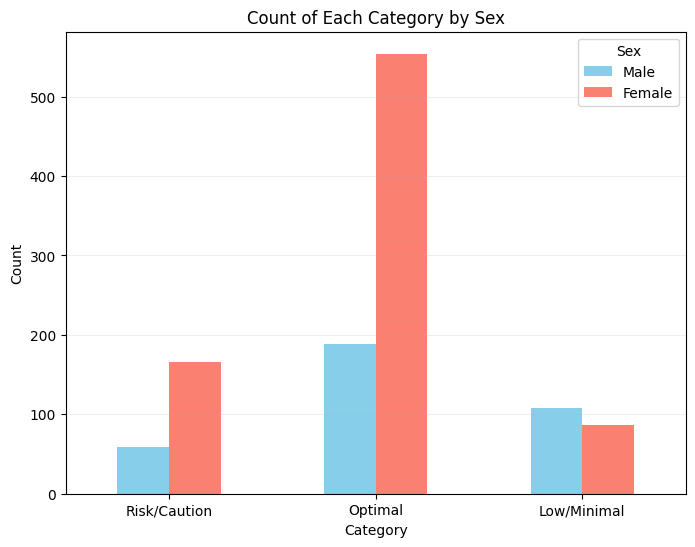

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by FatigInd and Sex_F, then count occurrences
contagem = pd.crosstab(df["FatigInd"], df["Sex_F"])

# Reindex to match the desired order of categories
contagem = contagem.reindex(["Risk/Caution", "Optimal", "Low/Minimal"])

# Plot the chart with bars separated by Sex_F
contagem.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'], figsize=(8, 6))
plt.title('Count of Each Category by Sex')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(['Male', 'Female'], title='Sex')
plt.grid(axis='y', alpha=0.2)
plt.xticks(rotation=0)
plt.show()


In [96]:
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler




y = df["FatigInd"] + " " + df["Sex_F"].astype(str)
X = df.drop(columns=["FatigInd", "Name", "Date"])



# Check the original class distribution
print("Original class distribution:", Counter(y))


classes = sorted(set(y))  # Get all unique class labels
smote_strategy = {}
undersampler_strategy = {}

# Update target size based on your needs
target_size = 108

# Ensure that undersampler_strategy accounts for classes that need to be upsampled
undersampler_strategy = {class_label: target_size if sum(y == class_label) > target_size else sum(y == class_label) for class_label in classes}

# Apply undersampling
undersampler = RandomUnderSampler(sampling_strategy=undersampler_strategy, random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

# Apply SMOTE with consistent target size
smote_strategy = {class_label: target_size for class_label in classes}
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_res, y_res = smote.fit_resample(X_under, y_under)

# Check final distribution
print("Final class distribution after resampling:", Counter(y_res))


balanced_df = X_res
balanced_df["Sex_F"] = y_res.map(lambda x: int(x.split()[1]))
balanced_df["FatigInd"] = y_res.map(lambda x: x.split()[0])


Original class distribution: Counter({'Optimal 1': 554, 'Optimal 0': 188, 'Risk/Caution 1': 166, 'Low/Minimal 0': 108, 'Low/Minimal 1': 86, 'Risk/Caution 0': 59})
Final class distribution after resampling: Counter({'Low/Minimal 0': 108, 'Low/Minimal 1': 108, 'Optimal 0': 108, 'Optimal 1': 108, 'Risk/Caution 0': 108, 'Risk/Caution 1': 108})


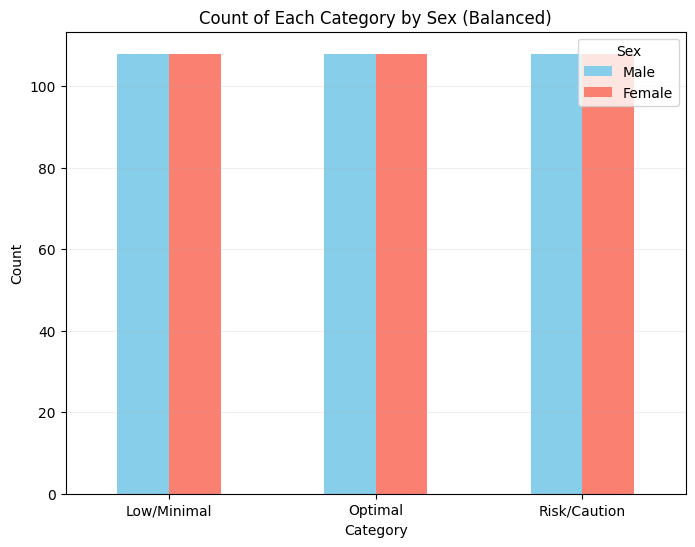

In [97]:
import matplotlib.pyplot as plt
import pandas as pd


balanced_contagem = pd.crosstab(balanced_df["FatigInd"], balanced_df["Sex_F"])

# Plot the balanced chart
balanced_contagem.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'], figsize=(8, 6))
plt.title('Count of Each Category by Sex (Balanced)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(['Male', 'Female'], title='Sex')
plt.grid(axis='y', alpha=0.2)
plt.xticks(rotation=0)
plt.show()


In [98]:
balanced_df

,Sex_F,Appetite,SleepInd,StSpirit,pEffort,uaI,uaI(-1),DeltaWt (%),DeltaHrtwo,FatigInd
0,0,4.000000,-6.000000,3.000000,1.0,0.000000,1.000000,-0.001761,-6.000000,Low/Minimal
1,0,3.000000,-5.500000,3.000000,5.0,2.440000,1.890000,-0.003546,19.000000,Low/Minimal
2,0,4.000000,-6.000000,4.000000,1.0,1.000000,0.000000,0.012500,12.000000,Low/Minimal
3,0,4.000000,-5.000000,3.000000,2.0,1.160000,1.560000,0.000000,-6.000000,Low/Minimal
4,0,4.000000,-5.000000,3.000000,2.0,2.910000,2.000000,0.001739,6.000000,Low/Minimal
...,...,...,...,...,...,...,...,...,...,...
643,0,4.971712,-3.966055,4.000000,5.0,2.060099,2.288486,0.008815,28.056576,Risk/Caution
644,0,4.000000,-4.000000,5.000000,5.0,2.000000,2.000000,0.000000,29.000000,Risk/Caution
645,0,4.000000,-3.500000,4.278270,6.0,2.216519,2.173215,0.000000,22.278270,Risk/Caution
646,0,4.000000,-3.235985,4.000000,6.0,2.668318,2.730326,-0.006992,19.707955,Risk/Caution


como temos demasiados ótimos, isto pode enviesar os resultados, ent é melhor apagarmos alguns do optimal e talvez do low. até ficar ao mesmo nivel do Risk. a diferenca entre risk e caution será insiginificante, e o minimal por ser um valor muito extremo pode ficar assim, ig

sao selecionadas ate ao limite, as primeiras de cada classe, pq as primeiras obs sao referentes aos atletas com maior qualidade de dados, digo eu, ou com mais importancia, se n pode se mudar "head" para "sample"

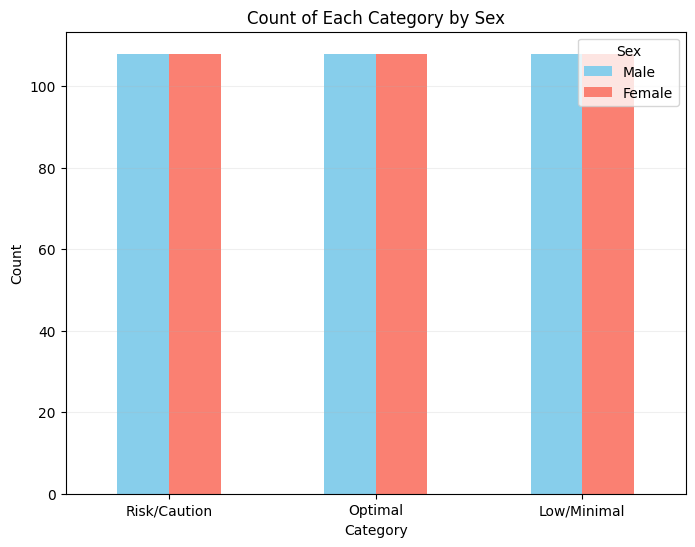

In [99]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by FatigInd and Sex_F, then count occurrences
contagem = pd.crosstab(balanced_df["FatigInd"], balanced_df["Sex_F"])

# Reindex to match the desired order of categories
contagem = contagem.reindex(["Risk/Caution", "Optimal", "Low/Minimal"])

# Plot the chart with bars separated by Sex_F
contagem.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'], figsize=(8, 6))
plt.title('Count of Each Category by Sex')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(['Male', 'Female'], title='Sex')
plt.grid(axis='y', alpha=0.2)
plt.xticks(rotation=0)
plt.show()


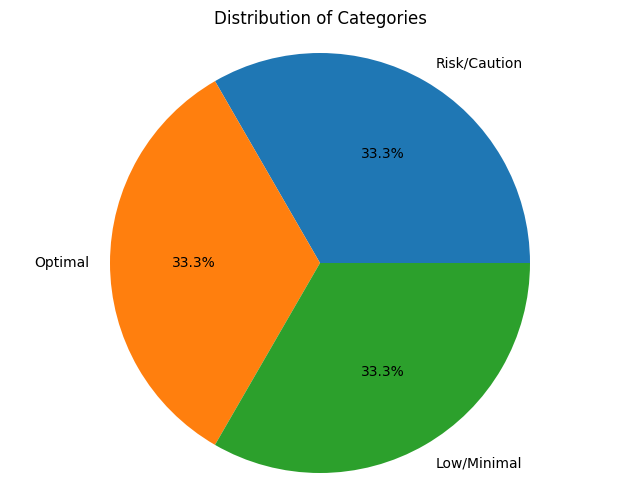

In [100]:
contagem = balanced_df["FatigInd"].value_counts()
contagem = contagem.reindex(["Risk/Caution", "Optimal", "Low/Minimal"])

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(contagem, labels=contagem.index, autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

---

# graficos de barras

In [101]:
balanced_df.columns

Index(['Sex_F', 'Appetite', 'SleepInd', 'StSpirit', 'pEffort', 'uaI',
       'uaI(-1)', 'DeltaWt (%)', 'DeltaHrtwo', 'FatigInd'],
      dtype='object')

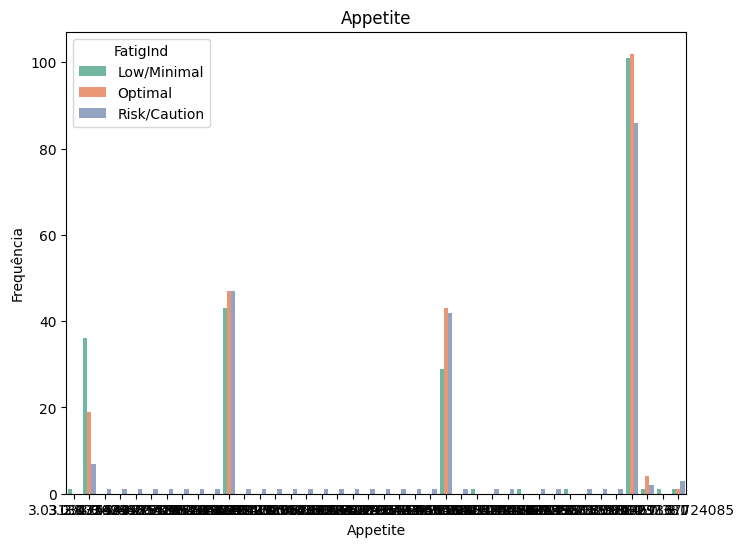

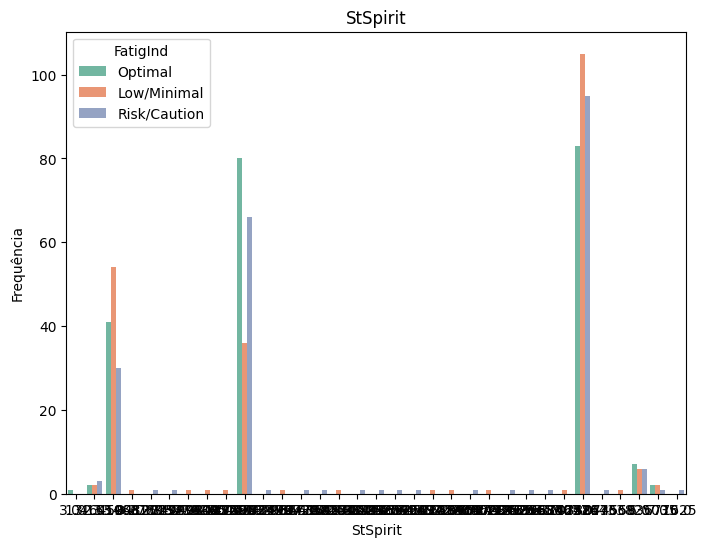

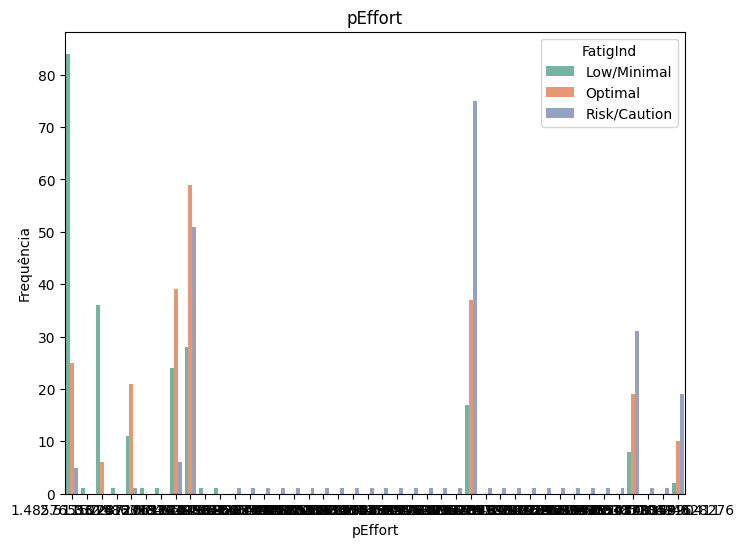

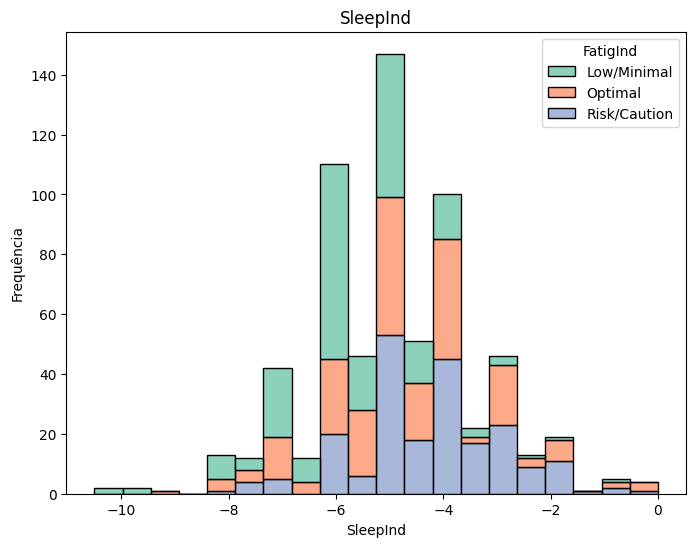

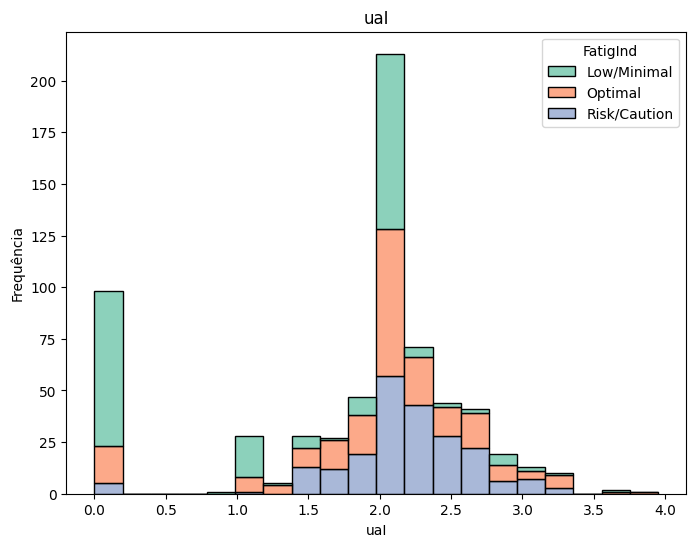

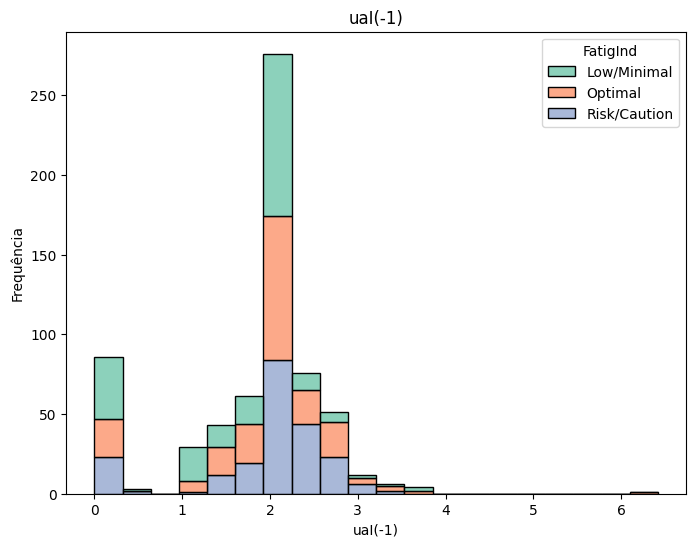

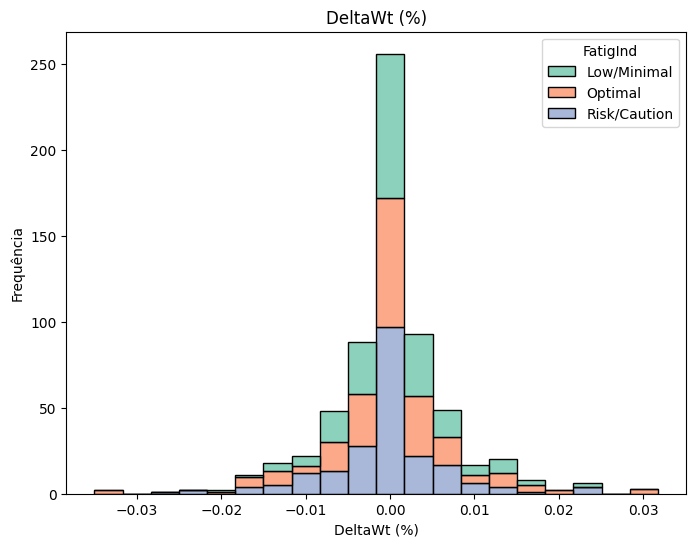

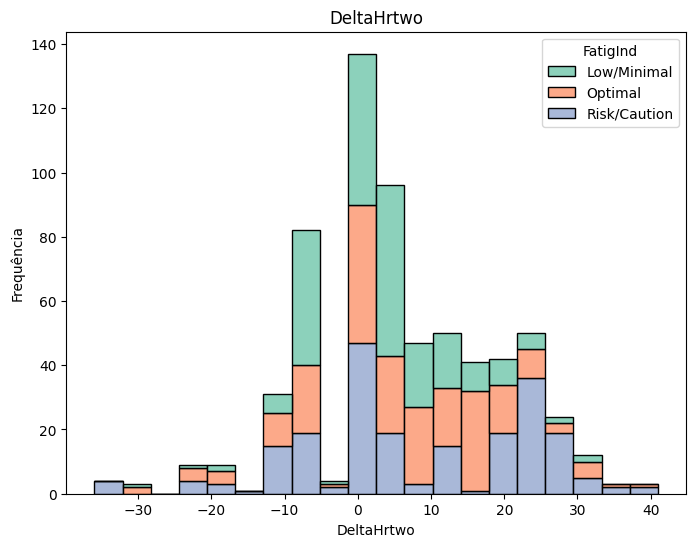

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Criando o DataFrame
dfGB = balanced_df

for cc in ['Appetite', 'StSpirit', 'pEffort']:

    # Criando o gráfico de barras com base em 'Appetite' e 'FatigInd'
    plt.figure(figsize=(8,6))
    sns.countplot(data=dfGB, x=cc, hue='FatigInd', palette='Set2')

    # Adicionando título e rótulos
    plt.title(f"{cc}")
    plt.xlabel(f'{cc}')
    plt.ylabel('Frequência')

    # Exibindo o gráfico
    plt.show()

for cc in ['SleepInd','uaI', 'uaI(-1)', 'DeltaWt (%)', 'DeltaHrtwo']:

    # Criando o gráfico de barras com base em 'Appetite' e 'FatigInd'
    plt.figure(figsize=(8,6))
    sns.histplot(data=dfGB, x=cc, hue='FatigInd', palette='Set2', bins=20, kde=False,multiple='stack')

    # Adicionando título e rótulos
    plt.title(f"{cc}")
    plt.xlabel(f'{cc}')
    plt.ylabel('Frequência')

    # Exibindo o gráfico
    plt.show()


# normalizacao

In [103]:
from sklearn.preprocessing import StandardScaler

# Separate numeric and non-numeric columns
numeric_cols = ['Appetite', 'SleepInd', 'StSpirit', 'pEffort',
                'uaI', 'uaI(-1)', 'DeltaWt (%)', 'DeltaHrtwo']

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize only the numeric columns
balanced_df[numeric_cols] = scaler.fit_transform(balanced_df[numeric_cols])

# Display the resulting DataFrame
print("DataFrame with standardized numeric columns only:")
balanced_df #sex_f nao devia ser standartizado


DataFrame with standardized numeric columns only:


,Sex_F,Appetite,SleepInd,StSpirit,pEffort,uaI,uaI(-1),DeltaWt (%),DeltaHrtwo,FatigInd
0,0,-0.966006,-0.734657,-1.434073,-1.624778,-2.051586,-0.946153,-0.266562,-0.953288,Low/Minimal
1,0,-1.874118,-0.397387,-1.434073,0.261186,0.750088,0.110060,-0.517570,1.016120,Low/Minimal
2,0,-0.966006,-0.734657,-0.347132,-1.624778,-0.903359,-2.132910,1.738161,0.464685,Low/Minimal
3,0,-0.966006,-0.060117,-1.434073,-1.153287,-0.719643,-0.281569,-0.019066,-0.953288,Low/Minimal
4,0,-0.966006,-0.060117,-1.434073,-1.153287,1.289755,0.240604,0.225418,-0.007973,Low/Minimal
...,...,...,...,...,...,...,...,...,...,...
643,0,-0.083583,0.637321,-0.347132,0.261186,0.313876,0.582967,1.220068,1.729563,Risk/Caution
644,0,-0.966006,0.614423,0.739810,0.261186,0.244868,0.240604,-0.019066,1.803883,Risk/Caution
645,0,-0.966006,0.951693,-0.044668,0.732677,0.493481,0.446168,-0.019066,1.274370,Risk/Caution
646,0,-0.966006,1.129782,-0.347132,0.732677,1.012249,1.107323,-1.001955,1.071890,Risk/Caution


## Análise bivariada (relações entre variáveis)

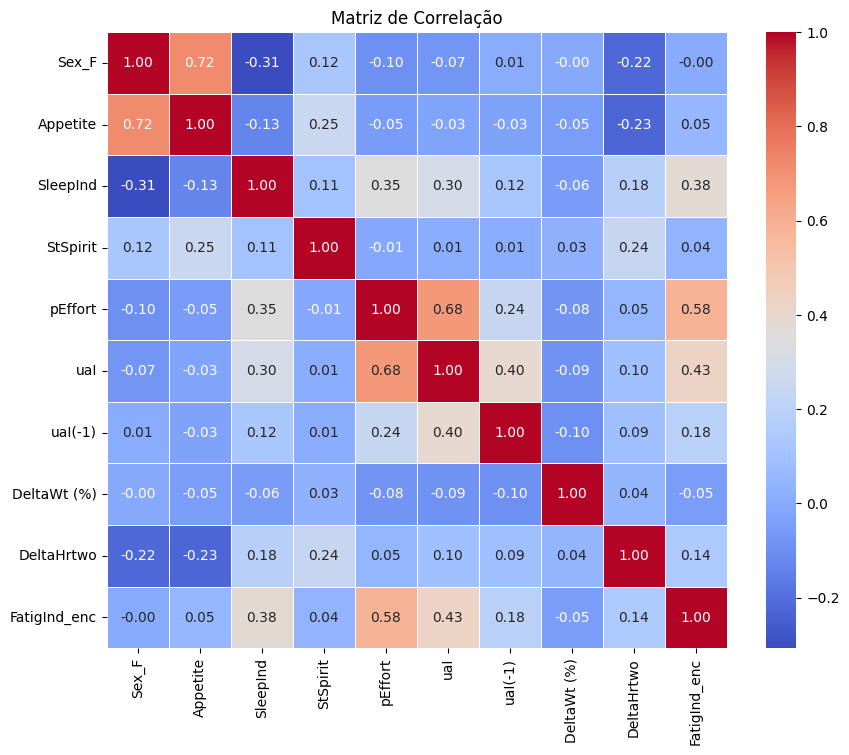

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Exemplo de DataFrame (substitua com seu próprio dataset)
# df = pd.read_csv('seu_arquivo.csv')
df_corr = balanced_df.copy()
df_corr = df_corr[['Sex_F', 'Appetite', 'SleepInd', 'StSpirit', 'pEffort',
       'uaI', 'uaI(-1)', 'DeltaWt (%)', 'DeltaHrtwo', 'FatigInd']]
       
# Codificar a variável target (se ela for categórica)
# Suponha que 'target' seja a variável categórica
encoder = LabelEncoder()
df_corr['FatigInd_enc'] = encoder.fit_transform(df_corr['FatigInd'])

# Selecione apenas as variáveis numéricas para calcular a correlação
df_numeric = df_corr.select_dtypes(include=['float64', 'int64'])

# Adicione a variável target codificada para análise de correlação
df_numeric['FatigInd_enc'] = df_corr['FatigInd_enc']

# Calcular a matriz de correlação
corr_matrix = df_numeric.corr()

# Plotando o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()


---
---
---

In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

filtered_df = balanced_df[balanced_df["Sex_F"] != 0.5] # so masculino, >0.5, so feminino


X = filtered_df[['Sex_F', 'Appetite', 'SleepInd', 'StSpirit', 'pEffort',
       'uaI', 'uaI(-1)', 'DeltaWt (%)', 'DeltaHrtwo']]
y = filtered_df['FatigInd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report for precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Display coefficients of the model (for each feature)
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Accuracy: 0.676923076923077
Confusion Matrix:
[[42  6  2]
 [11 16 14]
 [ 3  6 30]]
Classification Report:
              precision    recall  f1-score   support

 Low/Minimal       0.75      0.84      0.79        50
     Optimal       0.57      0.39      0.46        41
Risk/Caution       0.65      0.77      0.71        39

    accuracy                           0.68       130
   macro avg       0.66      0.67      0.65       130
weighted avg       0.66      0.68      0.66       130

Model Coefficients: [[-0.39902512 -0.23987549 -0.50349821  0.21282459 -0.78931151 -0.19049775
  -0.00957392 -0.05860243 -0.32772195]
 [-0.12684885  0.21538569  0.08651064 -0.19019446 -0.18803739  0.07500562
   0.02214738  0.07898277  0.0865073 ]
 [ 0.52587397  0.02448981  0.41698757 -0.02263013  0.9773489   0.11549213
  -0.01257346 -0.02038033  0.24121466]]
Intercept: [ 0.11063868  0.39006639 -0.50070507]


---
---
---